In [23]:
import pandas as pd
import json
import seaborn as sns
%matplotlib inline

In [32]:
df = pd.read_csv("../raw_data/nalogi.csv", header=None)
df.columns = ["Nałóg", "Daje", "Zwalcza"]

In [76]:
number_of_entries = len(df)
print(number_of_entries)

5972


In [33]:
df.head()

,Nałóg,Daje,Zwalcza
0,Kawa,Pozostałe,Niepokój
1,Pozostałe,Bezpieczeństwo,Lęk
2,Papierosy,Błogość,Odpowiedzialność
3,Pozostałe,Pozostałe,Słabość
4,Jedzenie,Pozostałe,Pustka


25


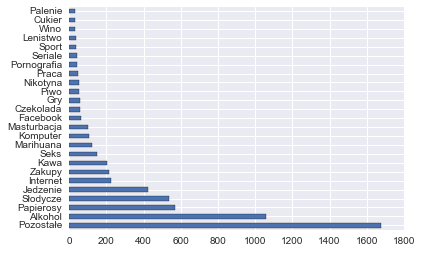

In [36]:
df.Nałóg.value_counts().plot('barh')
print(len(df.Nałóg.unique()))

44


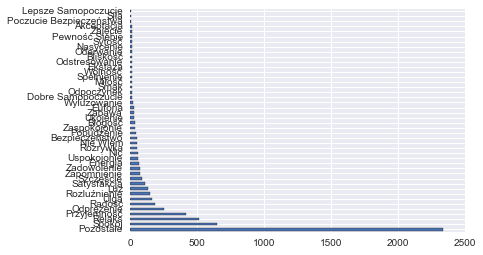

In [38]:
df.Daje.value_counts().plot('barh')
print(len(df.Daje.unique()))

49


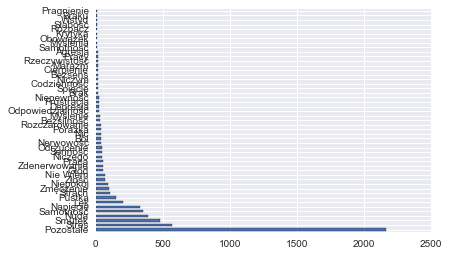

In [37]:
df.Zwalcza.value_counts().plot('barh')
print(len(df.Zwalcza.unique()))

In [47]:
nodes = pd.melt(df, var_name="category", value_name="name") \
  .groupby(["name", "category"]) \
  .size() \
  .reset_index() \
  .rename(columns={0: 'count'}) \
  .to_dict('records')
nodes[:5]

[{'category': 'Zwalcza', 'count': 13, 'name': 'Agresja'},
 {'category': 'Daje', 'count': 12, 'name': 'Akceptacja'},
 {'category': 'Nałóg', 'count': 1059, 'name': 'Alkohol'},
 {'category': 'Daje', 'count': 50, 'name': 'Bezpieczeństwo'},
 {'category': 'Zwalcza', 'count': 14, 'name': 'Bezsens'}]

In [62]:
nodes_lookup = {(each['name'], each['category']): {'count': each['count'], 'i': i}
                for i, each in enumerate(nodes)}

In [61]:
df.columns

Index(['Nałóg', 'Daje', 'Zwalcza'], dtype='object')

In [85]:
def links_for_a_pair(source, target):
    df_link = df.groupby([source, target]) \
      .size() \
      .reset_index() \
      .rename(columns={0: 'count', source: 'source', target: 'target'})

    df_link['source_count'] = df_link['source'].apply(lambda x: nodes_lookup[(x, source)]['count'])
    df_link['target_count'] = df_link['target'].apply(lambda x: nodes_lookup[(x, target)]['count'])
    df_link['oe'] = number_of_entries * df_link['count'] / (df_link['source_count'] * df_link['target_count'])
    df_link['source'] = df_link['source'].apply(lambda x: nodes_lookup[(x, source)]['i'])
    df_link['target'] = df_link['target'].apply(lambda x: nodes_lookup[(x, target)]['i'])

    # there is some error in Pandas resulting in floats!
    return  df_link[['source', 'target', 'count', 'oe']].to_dict("records")

In [87]:
links = links_for_a_pair(df.columns[0], df.columns[1]) \
        + links_for_a_pair(df.columns[1], df.columns[2]) \
        + links_for_a_pair(df.columns[2], df.columns[0])

In [88]:
links[:5]

[{'count': 4.0, 'oe': 0.66344498139199026, 'source': 2.0, 'target': 10.0},
 {'count': 3.0, 'oe': 0.89041300134188162, 'source': 2.0, 'target': 16.0},
 {'count': 1.0, 'oe': 0.37595215612212779, 'source': 2.0, 'target': 17.0},
 {'count': 1.0, 'oe': 0.086758189874337185, 'source': 2.0, 'target': 18.0},
 {'count': 3.0, 'oe': 0.58337403536192245, 'source': 2.0, 'target': 19.0}]

In [90]:
# fixing Pandas error by hand
for link in links:
    link['count'] = int(link['count'])
    link['source'] = int(link['source'])
    link['target'] = int(link['target'])

In [91]:
links[:5]

[{'count': 4, 'oe': 0.66344498139199026, 'source': 2, 'target': 10},
 {'count': 3, 'oe': 0.89041300134188162, 'source': 2, 'target': 16},
 {'count': 1, 'oe': 0.37595215612212779, 'source': 2, 'target': 17},
 {'count': 1, 'oe': 0.086758189874337185, 'source': 2, 'target': 18},
 {'count': 3, 'oe': 0.58337403536192245, 'source': 2, 'target': 19}]

In [92]:
len(links)

1684

In [95]:
len([link for link in links if link['oe'] > 0.9])

1143

In [99]:
len([link for link in links if link['count'] > 2])

799

In [103]:
len([link for link in links if link['count'] > 2 and link['oe'] > 0.7])

657

In [104]:
links = [link for link in links if link['count'] > 2 and link['oe'] > 0.7]

In [105]:
json.dump({"nodes": nodes, "links": links}, open("../data/nalogi.json", "w"), indent=2)